# Cloud Optimized Geotiff

In short, a cloud-optimized GeoTIFF (COG) is a geospatial data file format designed for efficient storage, access, and processing in cloud computing environments. It divides the image data into smaller tiles, includes multiple versions of the image at different resolutions, optimizes metadata organization, and supports incremental data retrieval. COGs enable faster data access and processing in the cloud, making them ideal for large-scale geospatial analysis and visualization.

> "As a cartographer of old, I have witnessed the winds of change carry our maps from parchment to pixels. The Cloud-Optimized GeoTIFF, a marvel of modern ingenuity, transcends the boundaries of time and space. It breathes life into geospatial data, transforming it into a nimble and scalable form that dances effortlessly across the celestial canvas. Like a masterful cartographic symphony, COG orchestrates the harmony between efficient storage, seamless access, and celestial processing, empowering explorers to chart uncharted territories with grace and precision."
>
> ChatGPT

- [Open Geospatial Consortium COG spec](https://github.com/opengeospatial/CloudOptimizedGeoTIFF)

To work with cogs, we will use `rio-cogeo`, `rio-tiler` and `cog-worker`

In [3]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import folium

import utils

In [5]:
!rio cogeo info ../data/sentinel_cog.tif

Driver: GTiff
File: /home/bielstela/vizzuality/dev/jornades-sig-lliure-propi/data/sentinel_cog.tif
COG: True
Compression: DEFLATE
ColorSpace: None

Profile
    Width:            10980
    Height:           10980
    Bands:            3
    Tiled:            True
    Dtype:            uint8
    NoData:           0.0
    Alpha Band:       False
    Internal Mask:    False
    Interleave:       PIXEL
    ColorMap:         False
    ColorInterp:      ('red', 'green', 'blue')
    Scales:           (1.0, 1.0, 1.0)
    Offsets:          (0.0, 0.0, 0.0)

Geo
    Crs:              EPSG:32636
    Origin:           (499980.0, 1900020.0)
    Resolution:       (10.0, -10.0)
    BoundingBox:      (499980.0, 1790220.0, 609780.0, 1900020.0)
    MinZoom:          8
    MaxZoom:          14

Image Metadata
    AREA_OR_POINT: Area
    OVR_RESAMPLING_ALG: AVERAGE

Image Structure
    COMPRESSION: DEFLATE
    INTERLEAVE: PIXEL
    PREDICTOR: 2

Band 1
    ColorInterp: red

Band 2
    ColorInterp: green

Ba

### Full raster

In [27]:
%%time
with rio.open("../data/sentinel_cog.tif") as src:
    data = src.read()
    source_crs = src.crs
    source_bounds = src.bounds

CPU times: user 2.49 s, sys: 215 ms, total: 2.71 s
Wall time: 2.71 s


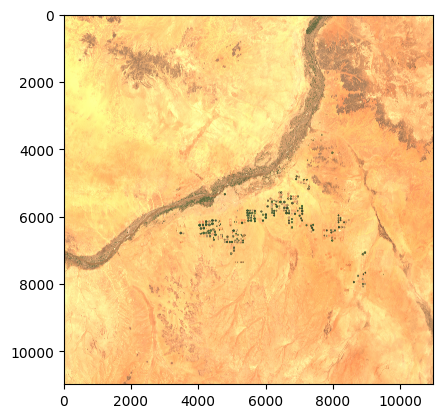

<Axes: >

In [41]:
rio.plot.show(data)

## Overviews

As we saw in the `info` of the cog the file has 4 levels of decimation like so:

In [42]:
decimations = [2**x for x in range(5)]
decimations

[1, 2, 4, 8, 16]

To demostrate that the overviews exists we will try to read a reduced resolution 

In [43]:
%%time
# If you want to be sure that rasterio is actually reading an overview just use the following. 
# removing the GDAL caches tricks and reading a shape that is not the one of an overview
# ... be warned that it takes a while
size = 1373
with rio.Env(VSI_CACHE=False, GDAL_CACHEMAX=0) as env:
    with rio.open("../data/sentinel_cog.tif") as src:
        out = np.empty((3,  size, size)).astype(src.profile['dtype'])
        out = src.read(out=out)

CPU times: user 55.6 ms, sys: 3.78 ms, total: 59.4 ms
Wall time: 57.6 ms


<timed exec>:7: RuntimeWarning: invalid value encountered in cast


(3, 10980, 10980)


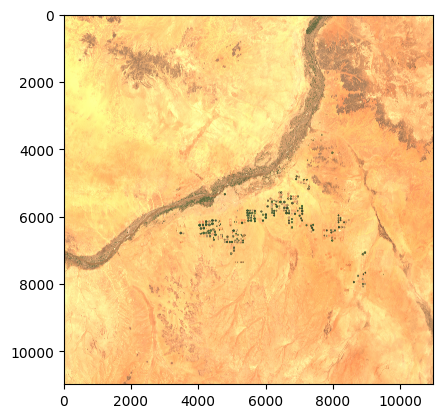

(3, 5490, 5490)


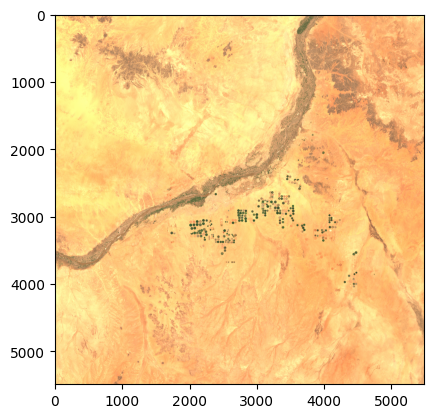

(3, 2745, 2745)


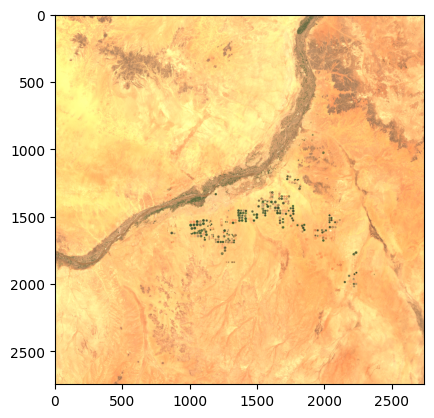

(3, 1372, 1372)


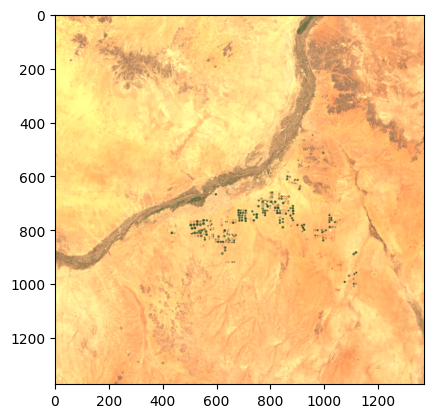

/tmp/ipykernel_20321/2014999187.py:9: RuntimeWarning: invalid value encountered in cast
  arr = np.empty(shape=out_shape).astype(src.profile['dtype'])


(3, 686, 686)


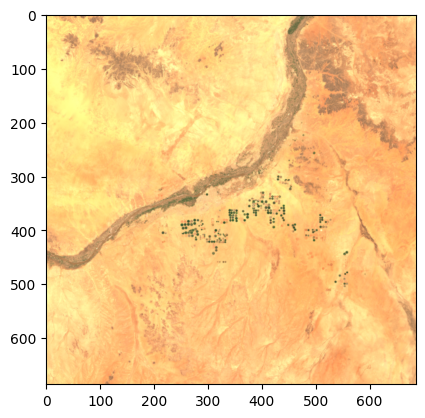

In [46]:
overviews = []
with rio.open("../data/sentinel_cog.tif") as src:
    bounds_4326 = rio.warp.transform_bounds(src.crs, "epsg:4316", *src.bounds)
    for overview_level in decimations:
        # Reading into an array with a specific shape, makes rasterio 
        # to read from the overviews. Controling the shape
        # we can control wich overview are we reading from
        out_shape = (3, src.shape[0]//overview_level , src.shape[1]//overview_level)
        arr = np.empty(shape=out_shape).astype(src.profile['dtype'])
        arr = src.read(out=arr)
        overviews.append(arr)
        print(out_shape)
        rio.plot.show(arr)


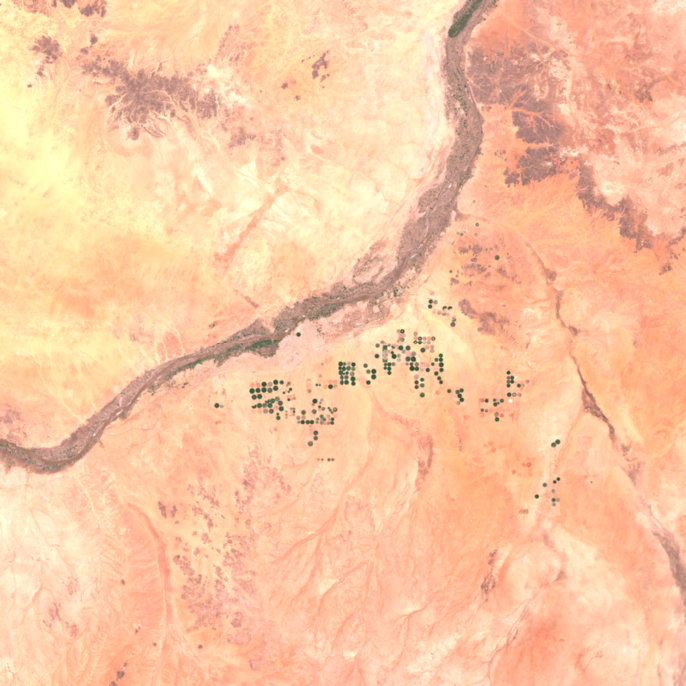

In [47]:
m = folium.Map([16.6, 33.4], zoom_start=11)
folium.raster_layers. ImageOverlay(
    image=rio.plot.reshape_as_image(overviews[-1]),
    bounds=utils.convert_bounds(bounds_4326),
).add_to(m)

folium.LayerControl().add_to(m)
m

## Tiles

COGs have internal tiling (overviews included). The flag `Tiled: True` indicates that the tof file has tiling. And in the last section 

we can inspect the tile sizes: 

```
IFD
    Id      Size           BlockSize     Decimation           
    0       10980x10980    1024x1024     0
    1       5490x5490      512x512       2
    2       2745x2745      512x512       4
    3       1373x1373      512x512       8
    4       687x687        512x512       16
```

why tiling?

![image](https://kokoalberti.com/articles/geotiff-compression-optimization-guide/tiled_vs_stripped.png)

In [48]:
%%timeit

# Play with the window size and offsets to see how the read time changes.
window_size = 1024
row_offset = 1024
col_offset = 1024
with rio.Env(VSI_CACHE=False, GDAL_CACHEMAX=0) as env:
    with rio.open("../data/sentinel_cog.tif") as src:
        window = rio.windows.Window(col_offset, row_offset, window_size, window_size)
        arr = src.read(1, window=window)

24.8 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## COG Worker

In [4]:
from rasterio.plot import show
import numpy as np
from cog_worker import Manager, Worker

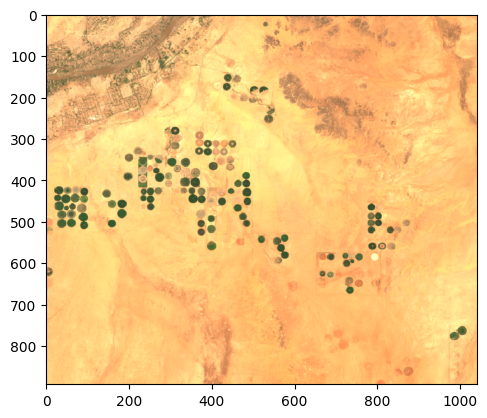

<Axes: >

In [5]:

bounds = [33.5, 16.5, 33.85, 16.8,]

def my_analysis(worker):
    arr = worker.read('../data/sentinel_cog.tif')
    return arr

manager = Manager(proj='epsg:4326', scale=0.086, bounds=bounds)
arr, bbox = manager.preview(my_analysis)
show(arr)

In [9]:
import scipy

def focal_mean(
    worker: Worker,
    src_path: str = None,
    kernel_radius: float = 1000 # radius in projection units (meters)
) -> np.ndarray:

    array = worker.read(src_path)

    # Access the pixel size at worker.scale
    kernel_size = kernel_radius * 2 / worker.scale
    array = scipy.ndimage.uniform_filter(array, (1, kernel_size, kernel_size))

    return array

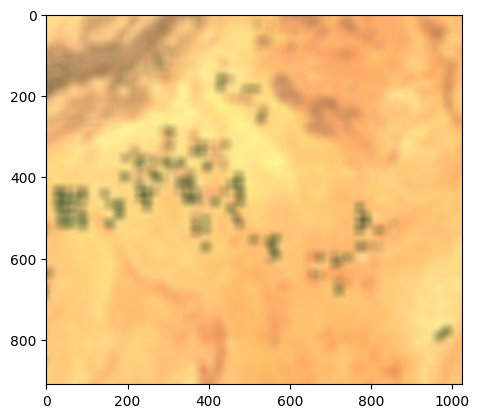

<Axes: >

In [38]:
bounds = [33.5, 16.5, 33.85, 16.8,]

manager = Manager(proj="epsg:3395", scale=30, bounds=bounds)
arr, bbox = manager.preview(focal_mean, f_kwargs={'src_path': '../data/sentinel_cog.tif', 'kernel_radius': 500})
show(arr)

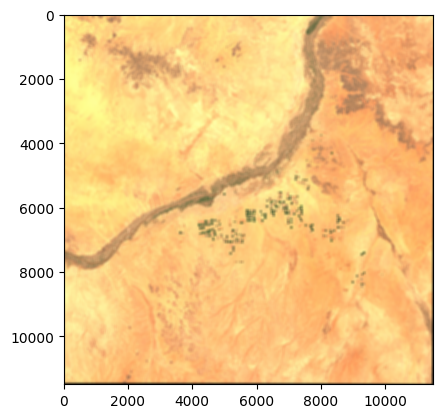

<Axes: >

In [40]:
# compute bbox in lat lon. 
bounds = rio.warp.transform_bounds(source_crs, "epsg:4326", *source_bounds)
manager = Manager(proj="epsg:3395", scale=10, bounds=bounds)
arr, box = manager.execute(focal_mean, f_kwargs={'src_path': '../data/sentinel_cog.tif', 'kernel_radius': 500})
show(arr)

## Make the cpu go brrrrrr with __Dask__

In [58]:
from cog_worker.distributed import DaskManager
from dask.distributed import LocalCluster, Client

client = Client()
client


/home/bielstela/mambaforge/envs/gis2/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34257 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34257/status,
Dashboard: http://127.0.0.1:34257/status,Workers: 8
Total threads: 8,Total memory: 15.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41443,Workers: 8
Dashboard: http://127.0.0.1:34257/status,Total threads: 8
Started: Just now,Total memory: 15.21 GiB
Comm: tcp://127.0.0.1:33837,Total threads: 1
Dashboard: http://127.0.0.1:43239/status,Memory: 1.90 GiB
Nanny: tcp://127.0.0.1:35515,


In [59]:

distributed_manager = DaskManager(
    client,
    proj="epsg:3395",
    scale=10,
    bounds=bounds,
    buffer = 128
)

# Execute in worker pool and save chunks to disk as they complete.
chunks = distributed_manager.chunk_execute(focal_mean, chunksize=2048, compute=True,  f_kwargs={'src_path': '../data/sentinel_cog.tif', 'kernel_radius': 500})
arrs = [a for a, _ in chunks]

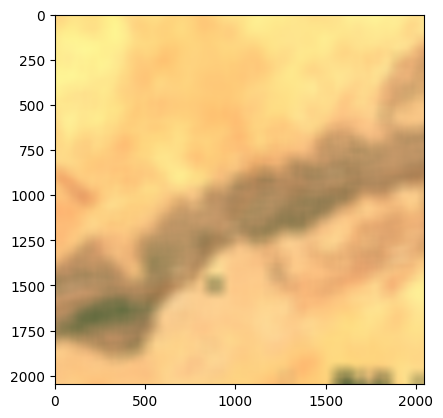

<Axes: >

In [55]:
show(arrs[15])